In [1]:
##### C.A.L. Bailer-Jones, Practical Bayesian Inference, 2017
##### Version 2017-03-24. CC-BY-4.0 licence (see README file)
#
# modified A. Schrimpf 12/2020
# modified N. Netter 01/2021

##### Bayesian inference of a 3-parameter linear model to 2D data
#
#
# This script uses JAGS - Jet another Gibbs Sampler
#
# The following cell needs to be run to install
# JAGS packages.

In [9]:
system("conda install -y -c conda-forge jags r-rjags")
Sys.setenv(http_proxy="http://www-proxy1.hrz.uni-marburg.de:3128")
Sys.setenv(https_proxy="http://www-proxy1.hrz.uni-marburg.de:3128")
install.packages("runjags")
install.packages("gplots")

In [5]:
library(gplots) # for plotCI


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




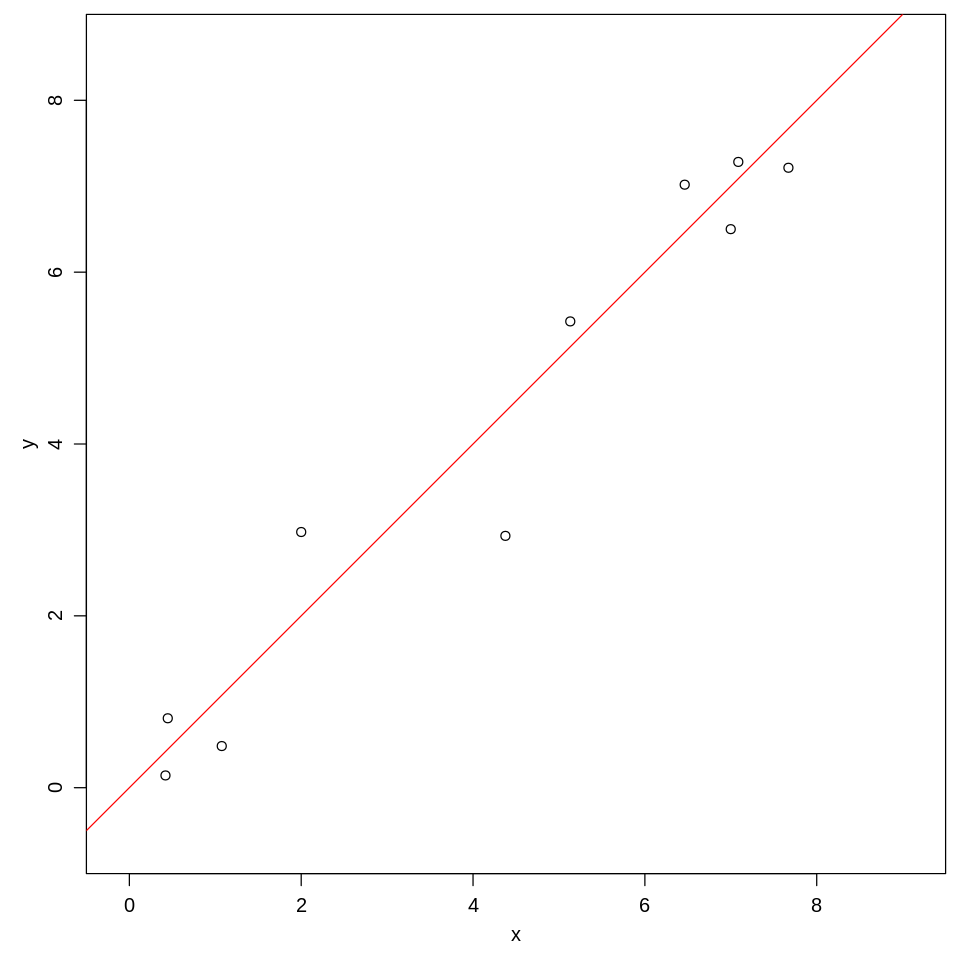

In [6]:
########## Define true model and simulate experimental data from it

set.seed(50)
Ndat <- 10
x <- sort(runif(Ndat, 0, 10))
sigTrue <- 1 # 0.1 # 1
modMat <- c(0,1) # 1 x P vector: coefficients, b_p, of sum_{p=0} b_p*x^p

y <- cbind(1,x) %*% as.matrix(modMat) + rnorm(Ndat, 0, sigTrue)

# Dimensions in the above: [Ndat x 1] = [Ndat x P] %*% [P x 1] + [Ndat]
# cbind does the logical thing when combining a scalar and vector, 
# then do vector addition

y <- drop(y) # converts into a vector

# plot data and true model

library(repr)
options(repr.plot.width=8,repr.plot.height=8)

# pdf("linearmodel_data.pdf", width=4, height=4)

par(mfrow=c(1,1), mar=c(3.5,3.5,0.5,0.5), oma=0.1*c(1,1,1,1), 
    mgp=c(2.0,0.8,0), cex=1.0)
plot(x, y, xlim=c(-0.5,9.5), ylim=c(-1,9), xaxs="i", yaxs="i")
abline(a=modMat[1], b=modMat[2], col="red") # true model

# dev.off()

# True parameters, transformed to conform with model to be used below
# thetaTrue <- c(modMat[1], atan(modMat[2]), log10(sigTrue))
thetaTrue <- c(modMat[1], atan(modMat[2]), log(sigTrue))
obsdata <- data.frame(cbind(x,y)) # columns must be named "x" and "y"
rm(x,y)



In [7]:
length(obsdata$x)

[1] 10

In [8]:
# install.packages('rjags')
library(rjags)
library(runjags)

# install.packages('mcmc')
#library(mcmc)

#
# library(fmcmc)
# https://www.rdocumentation.org/packages/fmcmc/versions/0.4-0/topics/MCMC


Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



### 1. runjags

In [9]:
model.jags <- "
model{
    for (i in 1:length(obsx)){
        modPred[i] <- theta_1 + tan(theta_2)*obsx[i]
        obsy[i] ~ dnorm(modPred[i], pow(exp(theta_3),-2))
    }
    # Gaussian prior on offset
    theta_1 ~  dnorm(0, pow(10,-2))
    # uniform prior on alpha, logsig
    theta_2  ~ dunif(-3.2,3.2) # -pi ... +pi
    theta_3  ~ dunif(-1.0E7,1.0e+7)

}
"

thetaInit <- c(2, pi/8, log(3))


results <- run.jags(model.jags,  data=list('obsx'=obsdata$x, 'obsy' = obsdata$y), 
                    inits=list(list('theta_1'=thetaInit[1], 'theta_2'=thetaInit[2], 'theta_3'=thetaInit[3]),
                               list('theta_1'=thetaInit[1], 'theta_2'=thetaInit[2], 'theta_3'=thetaInit[3]),
                               list('theta_1'=thetaInit[1], 'theta_2'=thetaInit[2], 'theta_3'=thetaInit[3])),
                    monitor=c('theta_1','theta_2','theta_3'), n.chains=3, method='rjags', sample=50000) # , plots=TRUE)


Compiling rjags model...
Calling the simulation using the rjags method...
Adapting the model for 1000 iterations...
Burning in the model for 4000 iterations...
Running the model for 50000 iterations...
Simulation complete
Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....
Finished running the simulation


In [10]:
print(results)


JAGS model summary statistics from 150000 samples (chains = 3; adapt+burnin = 5000):
                                                                           
         Lower95   Median Upper95     Mean       SD Mode      MCerr MC%ofSD
theta_1 -0.88316 0.041378  1.0715 0.050712  0.48759   --  0.0036703     0.8
theta_2  0.66265  0.76921 0.86425  0.76614 0.050837   -- 0.00039983     0.8
theta_3 -0.72008 -0.25925 0.30429 -0.23565   0.2678   --  0.0016669     0.6
                             
        SSeff    AC.10   psrf
theta_1 17649  0.07524 1.0002
theta_2 16166 0.089978 1.0003
theta_3 25812 0.018117      1

Total time taken: 2.7 seconds



In [11]:
str(results)

List of 44
 $ mcmc             :List of 3
  ..$ : 'mcmc' num [1:50000, 1:3] 1.03436 -0.53808 0.38723 0.00146 0.54924 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:50000] "5001" "5002" "5003" "5004" ...
  .. .. ..$ : chr [1:3] "theta_1" "theta_2" "theta_3"
  .. ..- attr(*, "mcpar")= num [1:3] 5001 55000 1
  ..$ : 'mcmc' num [1:50000, 1:3] -0.07779 0.00389 0.41866 -0.16976 -0.25633 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:50000] "5001" "5002" "5003" "5004" ...
  .. .. ..$ : chr [1:3] "theta_1" "theta_2" "theta_3"
  .. ..- attr(*, "mcpar")= num [1:3] 5001 55000 1
  ..$ : 'mcmc' num [1:50000, 1:3] -0.79 -0.963 -0.513 0.329 -0.602 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:50000] "5001" "5002" "5003" "5004" ...
  .. .. ..$ : chr [1:3] "theta_1" "theta_2" "theta_3"
  .. ..- attr(*, "mcpar")= num [1:3] 5001 55000 1
  ..- attr(*, "class")= chr "mcmc.list"
 $ deviance.table   : logi NA
 $ deviance.sum     : logi NA
 $ pd             

In [12]:
summary(results)

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta_1,-0.8831566,0.04137795,1.0714570,0.0507121,0.48758640,NA,0.0036702655,0.8,17649,0.07524019,1.000169
theta_2,0.6626457,0.76920541,0.8642488,0.7661412,0.05083685,NA,0.0003998278,0.8,16166,0.08997786,1.000269
theta_3,-0.7200828,-0.25925318,0.3042920,-0.2356526,0.26780156,NA,0.0016668632,0.6,25812,0.01811739,1.000016


In [13]:
# install.packages('bayesplot')
library("bayesplot")
library("ggplot2")

ERROR: Error in library("bayesplot"): there is no package called ‘bayesplot’


In [14]:
parnames <- c(expression(b[0]), expression(paste(alpha, " / rad")), 
             expression(paste(log, " ", sigma)))
parnames

expression(b[0], paste(alpha, " / rad"), paste(log, " ", sigma))

In [15]:

mcmc_pairs(results[[1]])

ERROR: Error in mcmc_pairs(results[[1]]): could not find function "mcmc_pairs"


In [16]:
# add contour
color_scheme_set("red")
p21 <- mcmc_scatter(as.matrix(results[[1]]), pars = c('theta_1','theta_2'), size = 0.5, alpha = 0.1)
p21 + stat_density_2d(color = "black", size = .5)
p22 <- mcmc_scatter(as.matrix(results[[1]]), pars = c('theta_1','theta_3'), size = 0.5, alpha = 0.1)
p22 + stat_density_2d(color = "black", size = .5)
p23 <- mcmc_scatter(as.matrix(results[[1]]), pars = c('theta_2','theta_3'), size = 0.5, alpha = 0.1)
p23 + stat_density_2d(color = "black", size = .5)

ERROR: Error in color_scheme_set("red"): could not find function "color_scheme_set"


In [17]:
summary(results)

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta_1,-0.8831566,0.04137795,1.0714570,0.0507121,0.48758640,NA,0.0036702655,0.8,17649,0.07524019,1.000169
theta_2,0.6626457,0.76920541,0.8642488,0.7661412,0.05083685,NA,0.0003998278,0.8,16166,0.08997786,1.000269
theta_3,-0.7200828,-0.25925318,0.3042920,-0.2356526,0.26780156,NA,0.0016668632,0.6,25812,0.01811739,1.000016


In [18]:
summary(results)[1,4]

[1] 0.0507121

In [19]:
thetaMean <- thetaTrue
thetaMean[1] <- summary(results)[1,4]
thetaMean[2] <- summary(results)[2,4]
thetaMean[3] <- summary(results)[3,4]

thetaMean

[1]  0.0507121  0.7661412 -0.2356526

In [20]:
tan(thetaMean[2]) # transform alpha to b_1
mean(exp(thetaMean[3])) # transform log10(sigma) to sigma

[1] 0.9622091

[1] 0.7900551

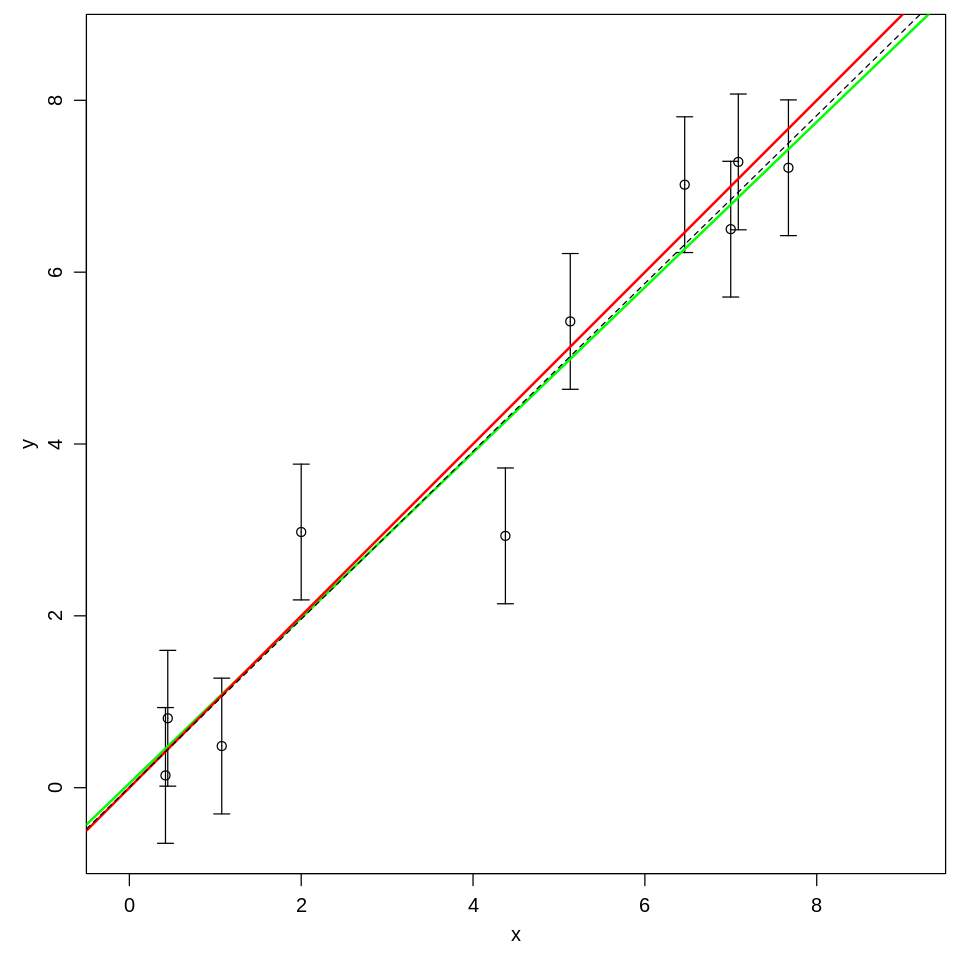

In [21]:
# Overplot these solutions with original data

library(repr)
options(repr.plot.width=8,repr.plot.height=8)

# pdf("linearmodel_fits.pdf", width=4, height=4)

par(mfrow=c(1,1), mar=c(3.5,3.5,0.5,0.5), oma=0.1*c(1,1,1,1), 
    mgp=c(2.0,0.8,0), cex=1.0)
plotCI(obsdata$x, obsdata$y, xlim=c(-0.5,9.5), ylim=c(-1,9), xaxs="i", yaxs="i",
       #xlab="x", ylab="y", uiw=exp(thetaMAP[3]), gap=0)
       xlab="x", ylab="y", uiw=exp(thetaMean[3]), gap=0)
#abline(a=thetaMAP[1], b=tan(thetaMAP[2]), lw=2, col='green')     # MAP  model
abline(a=thetaMean[1], b=tan(thetaMean[2]), lw=2, col='green')     # MEAN  model
abline(a=modMat[1],   b=modMat[2], col="red", lw=2) # true model
#
# Compare this with the result from ML estimation from lm()
abline(lm(obsdata$y ~ obsdata$x), col="black", lty=2)

# dev.off()

### 2. rjags

In [22]:
thetaInit <- c(2, pi/8, log(3))

m <- jags.model("linearmodel.bug", data=list('obsx'=obsdata$x, 'obsy' = obsdata$y),inits=list(
                        'theta_1'=2, 'theta_2' = pi/8, 'theta_3'= log(3)), 
                n.chains=3, n.adapt=1000)

Warning message in file(modfile, "rt"):
“cannot open file 'linearmodel.bug': No such file or directory”


Error in file(modfile, "rt") : cannot open the connection


ERROR: Error in jags.model("linearmodel.bug", data = list(obsx = obsdata$x, obsy = obsdata$y), : Cannot open model file "linearmodel.bug"


In [23]:
print(m)

ERROR: Error in print(m): object 'm' not found


In [55]:
mcmc.samples <- coda.samples(m, c('theta_1', 'theta_2','theta_3'), n.iter=5000)

In [56]:
str(mcmc.samples)

List of 3
 $ : 'mcmc' num [1:5000, 1:3] -0.415 -1.198 -0.564 -0.409 -0.169 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:3] "theta_1" "theta_2" "theta_3"
  ..- attr(*, "mcpar")= num [1:3] 1001 6000 1
 $ : 'mcmc' num [1:5000, 1:3] 0.6264 0.6287 0.6448 -0.199 -0.0613 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:3] "theta_1" "theta_2" "theta_3"
  ..- attr(*, "mcpar")= num [1:3] 1001 6000 1
 $ : 'mcmc' num [1:5000, 1:3] -0.0516 -0.1928 0.3467 0.0197 0.4706 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:3] "theta_1" "theta_2" "theta_3"
  ..- attr(*, "mcpar")= num [1:3] 1001 6000 1
 - attr(*, "class")= chr "mcmc.list"


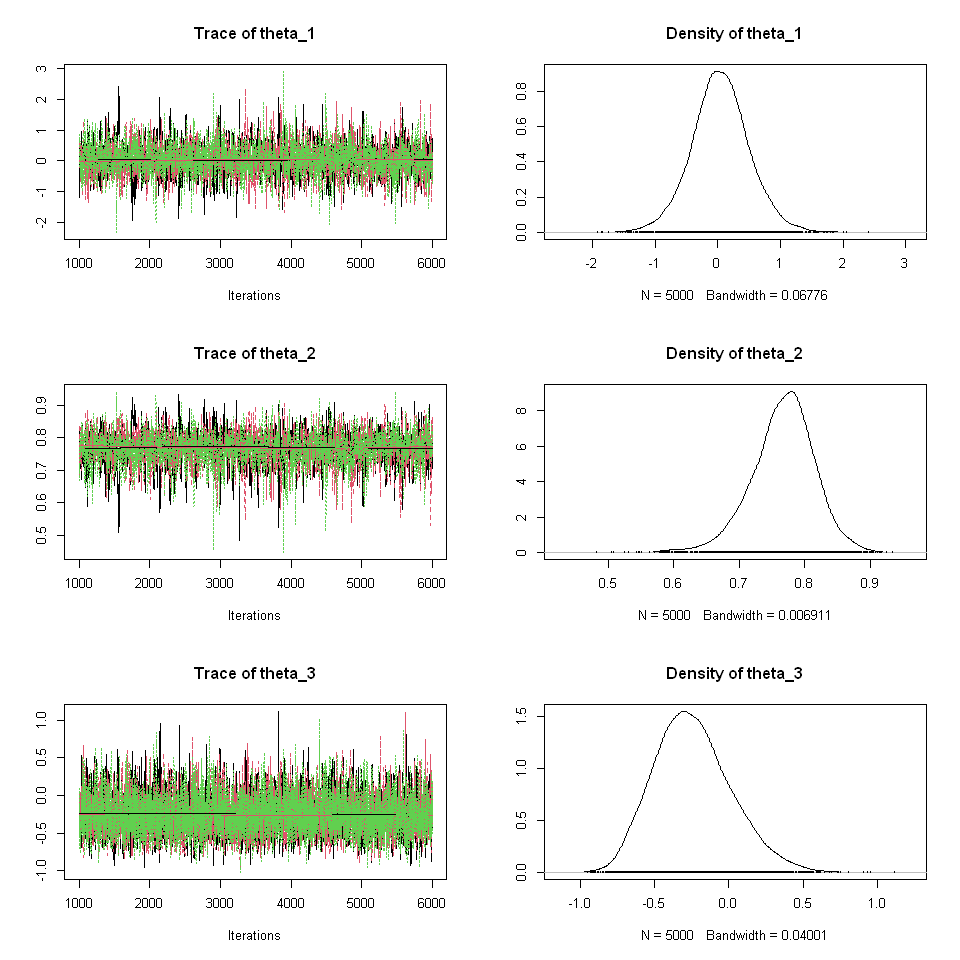

In [57]:
plot(mcmc.samples)

In [58]:
summary(mcmc.samples)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean      SD Naive SE Time-series SE
theta_1  0.04554 0.47165 0.003851       0.010264
theta_2  0.76651 0.04948 0.000404       0.001148
theta_3 -0.24208 0.26255 0.002144       0.003535

2. Quantiles for each variable:

           2.5%     25%      50%      75%  97.5%
theta_1 -0.8867 -0.2493  0.03959  0.33676 1.0010
theta_2  0.6592  0.7386  0.77011  0.79833 0.8569
theta_3 -0.6948 -0.4261 -0.26181 -0.08002 0.3266


In [59]:
thetaMean <- thetaTrue
thetaMean[1] <- mean(unlist(mcmc.samples[,1]))
thetaMean[2] <- mean(unlist(mcmc.samples[,2]))
thetaMean[3] <- mean(unlist(mcmc.samples[,3]))

thetaMean

[1]  0.04554262  0.76650712 -0.24207524

In [60]:
thetaMean

[1]  0.04554262  0.76650712 -0.24207524

In [61]:
tan(thetaMean[2]) # transform alpha to b_1
mean(exp(thetaMean[3])) # transform log10(sigma) to sigma

[1] 0.9629141

[1] 0.7849971

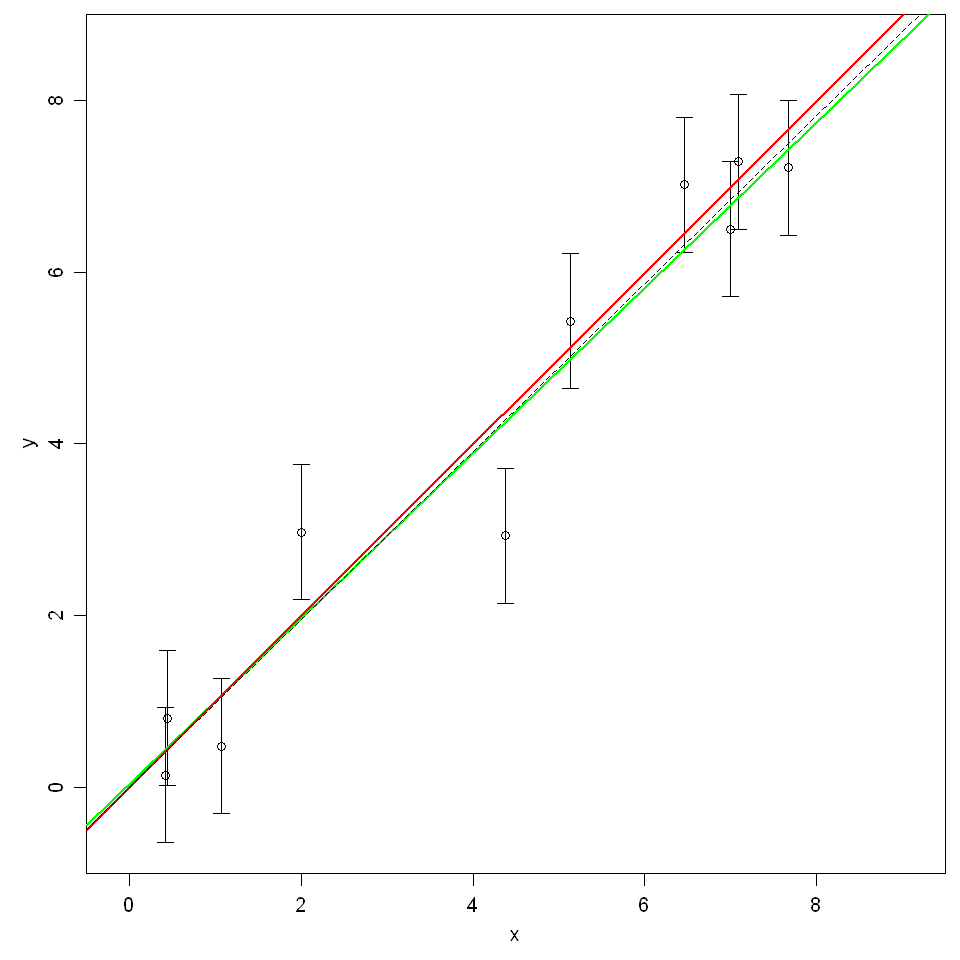

In [62]:
# Overplot these solutions with original data
library(gplots) # for plotCI
library(repr)
options(repr.plot.width=8,repr.plot.height=8)

# pdf("linearmodel_fits.pdf", width=4, height=4)

par(mfrow=c(1,1), mar=c(3.5,3.5,0.5,0.5), oma=0.1*c(1,1,1,1), 
    mgp=c(2.0,0.8,0), cex=1.0)
plotCI(obsdata$x, obsdata$y, xlim=c(-0.5,9.5), ylim=c(-1,9), xaxs="i", yaxs="i",
       #xlab="x", ylab="y", uiw=exp(thetaMAP[3]), gap=0)
       xlab="x", ylab="y", uiw=exp(thetaMean[3]), gap=0)
#abline(a=thetaMAP[1], b=tan(thetaMAP[2]), lw=2, col='green')     # MAP  model
abline(a=thetaMean[1], b=tan(thetaMean[2]), lw=2, col='green')     # MEAN  model
abline(a=modMat[1],   b=modMat[2], col="red", lw=2) # true model
#
# Compare this with the result from ML estimation from lm()
abline(lm(obsdata$y ~ obsdata$x), col="black", lty=2)

# dev.off()


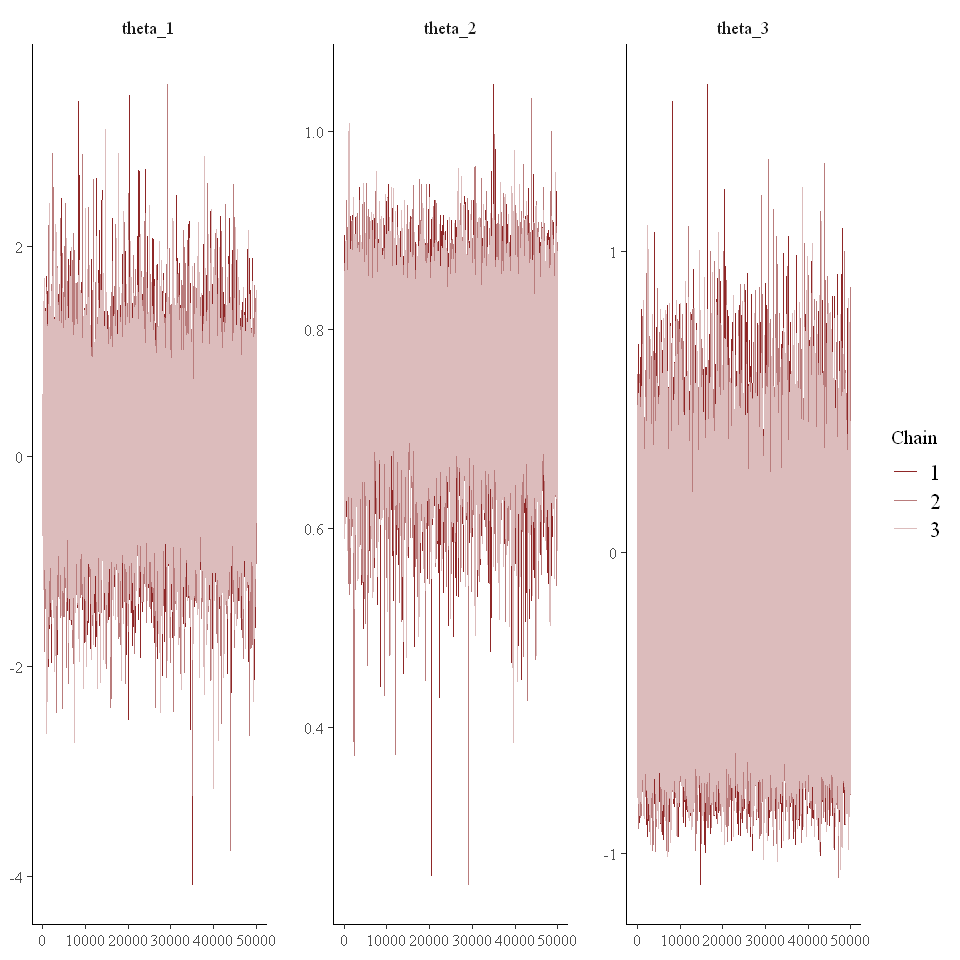

In [63]:
# install.packages('bayesplot')
library("bayesplot")
library("ggplot2")

mcmc_trace(results[[1]])